# Survive your commuting


In [1]:
#import
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import folium.plugins

> First, we define some global variables used to download the dataset. Since we have data across three different periods (1979 - 2004, 2004 - 2014, 2015), we merge all of them into a single dataframe for each category. To do so, we have to make the three datasets compatible with each other: we decided to remove some columns which where not used across all periods and which do not add relevant information for our approach, as of now.  

In [8]:
#Global
DATA_FOLDER = [
               './data/Stats19-Data1979-2004/', 
               './data/Stats19_Data_2005-2014/', 
               './data/RoadSafetyData_2015/']

#columns we want to extract from each file
use_cols = [[#Space and time context
            'Date','Time', 'Longitude', 'Latitude','Day_of_Week',
            #Identifier
            'Accident_Index', 
            #Police force related
            'Police_Force', 'Local_Authority_(District)', 'Local_Authority_(Highway)','Did_Police_Officer_Attend_Scene_of_Accident',
            #Casualties
            'Accident_Severity', 'Number_of_Casualties','Number_of_Vehicles',
            #Road conditions and traffic signalisations
            '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit', 'Junction_Detail', 'Junction_Control',
            '2nd_Road_Class', '2nd_Road_Number',
            #Pedestrian 
            'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 
            #Visibility and road conditions
            'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Special_Conditions_at_Site', 'Carriageway_Hazards',
            'Urban_or_Rural_Area', 
            #'Location_Easting_OSGR','Location_Northing_OSGR', 'LSOA_of_Accident_Location',
           ],
    #casualties
    ['Accident_Index', 'Age_Band_of_Casualty',
     #'Age_of_Casualty', 
     'Bus_or_Coach_Passenger', 'Car_Passenger',
     'Casualty_Class', 'Casualty_Home_Area_Type', 
     #'Casualty_IMD_Decile',
     'Casualty_Reference', 'Casualty_Severity', 'Casualty_Type',
     'Pedestrian_Location', 'Pedestrian_Movement',
     'Pedestrian_Road_Maintenance_Worker', 'Sex_of_Casualty',
     'Vehicle_Reference'],
    #vehicules
    ['Accident_Index', '1st_Point_of_Impact',
     'Age_Band_of_Driver', 
     #'Age_of_Driver', 
     'Age_of_Vehicle','Driver_Home_Area_Type', 'Driver_IMD_Decile', 'Engine_Capacity_(CC)',
     'Hit_Object_in_Carriageway', 'Hit_Object_off_Carriageway',
     'Journey_Purpose_of_Driver', 'Junction_Location', 'Propulsion_Code',
     'Sex_of_Driver', 'Skidding_and_Overturning', 'Towing_and_Articulation',
     #'Vehicle_IMD_Decile', 
     'Vehicle_Leaving_Carriageway',
     'Vehicle_Location-Restricted_Lane', 'Vehicle_Manoeuvre',
     'Vehicle_Reference', 'Vehicle_Type', 'Was_Vehicle_Left_Hand_Drive?']
]

#features legends
LEGENDS = pd.read_excel(DATA_FOLDER[0] + 'Road-Accident-Safety-Data-Guide-1979-2004.xls',
                        sheet_name = None,
                       )
#modify legend names to match with df features
for k in [k for k in LEGENDS.keys()]:
    LEGENDS[k.replace(' ', '_')] = LEGENDS.pop(k)


In [31]:
#HELPERS

def plot_distrib(acc, group = "Day_of_Week", colname = 'index', ax = None):
    """
    Plot the distribution of colname per group
    """
    if colname == 'index':
        acc[acc[group] != -1].groupby([group]).count().iloc[:,0].plot.bar(x = group, 
                                                       title = "Accidents distribution per {}".format(group),
                                                       ax = ax)
    else:
        acc[acc[group] != -1].groupby([group])[colname].sum().plot.bar(x = group, 
                                                     title = "{} distribution per {}".format(colname, group),
                                                     ax = ax)                        

        
def categorical_labels(df):
    for col in list(set(LEGENDS.keys() & df.columns)):
        try:
            df[col].replace( list(LEGENDS[col]['code']), LEGENDS[col]['label'], inplace = True)
        except KeyError:
            df[col].replace( list(LEGENDS[col]['Code']), LEGENDS[col]['Label'], inplace = True)
            pass
    
    return df
    


>We decided not to use the oldest data because it has a lot of missing values in addition with being completely outdated. This choice was also motivated by the deprecation of its format: it lacks some features and some feature names have been changed for the two other periods.

In [10]:
#load data
if True:
    df_list = [[] for i in range(3)]
    
    #for every period
    for file in DATA_FOLDER[1:]:
        
        #for every dataset (accidents, casualties, vehicules)
        files = sorted([doc for doc in os.listdir(file) if ".xls" not in doc and doc != '.DS_Store'])
        for doc in files:
            print(doc)
            index = files.index(doc)
            if index == 0:
                df_list[index].append(pd.read_csv(file + doc, 
                                                  index_col= "Accident_Index",
                                                  parse_dates=['Date'],
                                                  dayfirst=True,
                                                  infer_datetime_format=True,
                                                  usecols = use_cols[index],
                                       ))
            else:
                df_list[index].append(pd.read_csv(file + doc,
                                                  usecols = use_cols[index],
                                       ))
    
    accidents = pd.concat(df_list[0], axis = 0, ignore_index = True)

    casualties = pd.concat(df_list[1], axis = 0, ignore_index = True)

    vehicules = pd.concat(df_list[2], axis = 0, ignore_index = True)


years = np.arange(2005, 2015)
accidents['Casualties'] = casualties.groupby('Accident_Index').count()['Casualty_Reference']

Accidents0514.csv
Casualties0514.csv
Vehicles0514.csv
Accidents_2015.csv


/anaconda3/envs/xadax/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Casualties_2015.csv
Vehicles_2015.csv


> Once the dataset is downloaded, we have to clean it in order to make it usable: to do so we remove the '-1' values which correspond to unknown data or missing values.

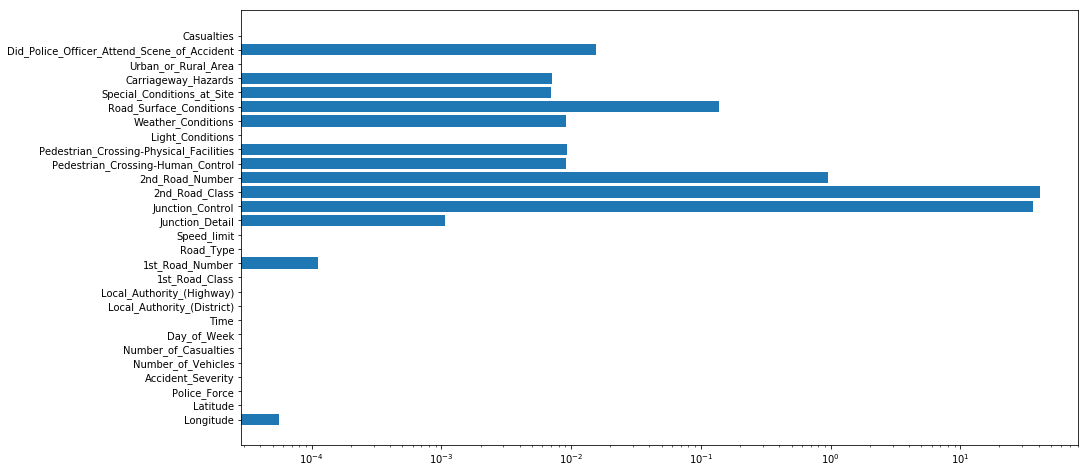

In [11]:
# Cleaning the dataset
percentage_of_nan = {}
columns = [col for col in accidents.columns if not col == 'Date']
for col in columns:
    percentage_of_nan[col] = (accidents[col] == -1 + accidents[col].isnull()).sum() / len(accidents) * 100
x = np.arange(len(percentage_of_nan))
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.barh(x, list(percentage_of_nan.values()), tick_label=list(percentage_of_nan.keys()), log=True);

> This plot show that rows are mostly complete. Some columns are full of missing values but these missing values are still meaningfull: for instance, there is not always a second road if the accident did not take place at an intersection. That's why we keep rows with missing values for some features. On the contrary, columns relevant to the accident's position (Latitude and longitude) have only few missing values which we need to remove to plot the map.

In [12]:
accidents = accidents[accidents.Latitude.notnull() & accidents.Longitude.notnull()]

> We know that the names of the legends do not fit the name of the features, we need to replace whitespace by underscore. Then for each dataframe, we turn its "numerical categorical" values into its categorical value/

In [32]:
#modify legend names to match with df features
for k in [k for k in LEGENDS.keys()]:
    LEGENDS[k.replace(' ', '_')] = LEGENDS.pop(k)

#let's map numerica categorical data to their label:
accidents = categorical_labels(accidents)
casualties = categorical_labels(casualties)
vehicules = categorical_labels(vehicules)

accidents.head()

,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),...,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,Casualties
0,-0.191170,51.489096,Metropolitan Police,Serious,1,1,2005-01-04,Tuesday,17:42,Kensington and Chelsea,...,0,1,Daylight,2,2,None,None,1,1,NaN
1,-0.211708,51.520075,Metropolitan Police,Slight,1,1,2005-01-05,Wednesday,17:36,Kensington and Chelsea,...,0,5,Darkness - lights lit,1,1,None,None,1,1,NaN
2,-0.206458,51.525301,Metropolitan Police,Slight,2,1,2005-01-06,Thursday,00:15,Kensington and Chelsea,...,0,0,Darkness - lights lit,1,1,None,None,1,1,NaN
3,-0.173862,51.482442,Metropolitan Police,Slight,1,1,2005-01-07,Friday,10:35,Kensington and Chelsea,...,0,0,Daylight,1,1,None,None,1,1,NaN
4,-0.156618,51.495752,Metropolitan Police,Slight,1,1,2005-01-10,Monday,21:13,Kensington and Chelsea,...,0,0,Darkness - lighting unknown,1,2,None,None,1,1,NaN


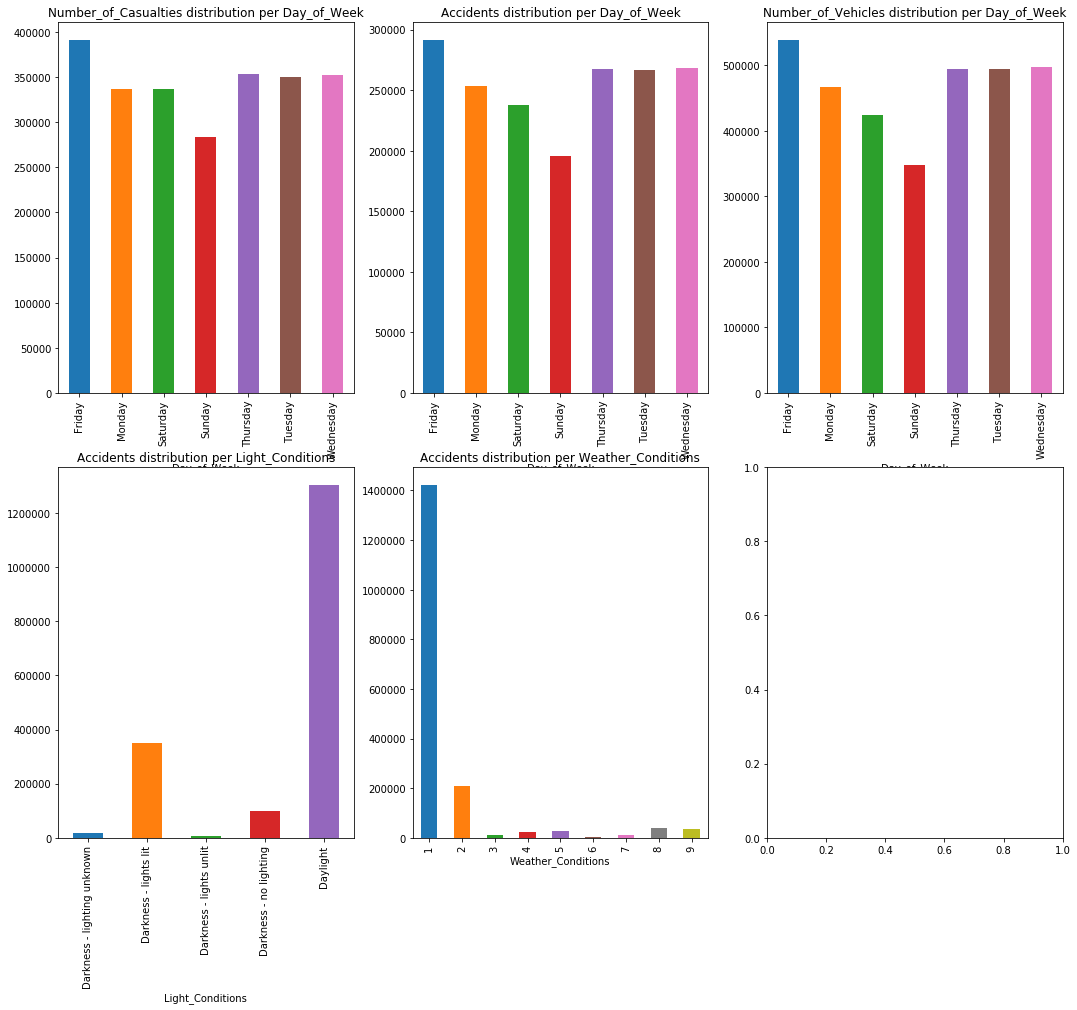

In [36]:
#Weekly distribution, plots using the accidents dataframe
fig, axes = plt.subplots(2, 3, figsize=(18, 15))
plot_distrib(accidents, colname = "Number_of_Casualties", ax = axes[0][0])
plot_distrib(accidents, ax = axes[0][1])
plot_distrib(accidents, colname = "Number_of_Vehicles", ax = axes[0][2])
plot_distrib(accidents, group = "Light_Conditions", ax = axes[1][0])
plot_distrib(accidents, group = "Weather_Conditions", ax = axes[1][1])


> Weekly distribution: Sunday has the lowest rate: people may take less frequently their cars. On the contrary, Friday seems to be the worst, is it due to the week-end leave ? We could dig deeper to see if it is equally distributed between morning and afternoon... 

> There are more wounded people but less vehicles on Sunday compared to Monday. It could explain by the fact that on Sunday people are traveling with their family: cars are almost full. While, on Monday it is more often commute paths where there are usually only person in the car

> We need to have more data to draw any conclusions regarding the light and weather conditions: we can sse that there is more accidents for a particular set of conditions but it is likely to be the most common set.


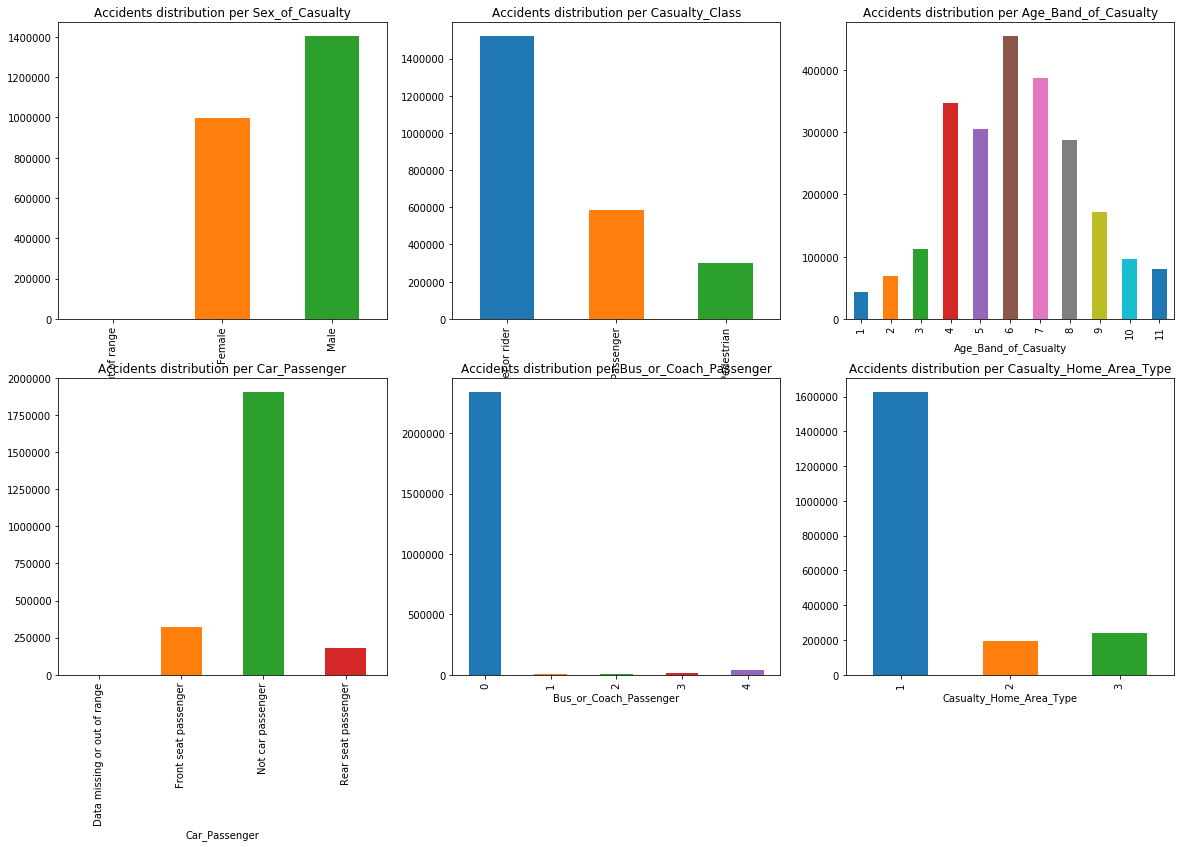

In [37]:
#plot using the casualties dataframe
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
plot_distrib(casualties, group = "Sex_of_Casualty", ax = axes[0][0])
plot_distrib(casualties, group = "Casualty_Class", ax = axes[0][1])
plot_distrib(casualties, group = "Age_Band_of_Casualty", ax = axes[0][2])
plot_distrib(casualties, group = "Car_Passenger", ax = axes[1][0])
plot_distrib(casualties, group = "Bus_or_Coach_Passenger", ax = axes[1][1])
plot_distrib(casualties, group = "Casualty_Home_Area_Type", ax = axes[1][2])


> We can see that there are an interesting distribution of the number of casualties among the gender and age features.

In [38]:
london_coord = [55.3780518, -3.4359729]

In [39]:
# Plot every accidents in the UK from 2005 to 2014
m = folium.Map(location=london_coord, zoom_start=5)
marker_cluster = folium.plugins.marker_cluster.MarkerCluster().add_to(m)
for acc in accidents.sample(1000).itertuples():
    folium.Marker([acc.Latitude, acc.Longitude]).add_to(marker_cluster)
m

TypeError: __init__() missing 1 required positional argument: 'locations'

In [80]:
# Plot the approximate density of accidents in the UK
m = folium.Map(location=london_coord, zoom_start=5)
folium.plugins.HeatMap(accidents[['Latitude', 'Longitude']].sample(1000).values).add_to(m)
m

In [81]:
# Plot the approximate density of accidents in the UK year per year
m = folium.Map(location=london_coord, zoom_start=5)
folium.plugins.HeatMapWithTime([accidents[['Latitude', 'Longitude']][accidents.Date.dt.year == y].sample(1000).values.tolist()
                                for y in years]).add_to(m)
m

AttributeError: module 'folium.plugins' has no attribute 'HeatMapWithTime'

ValueError: x and y must have same first dimension, but have shapes (10,) and (11,)

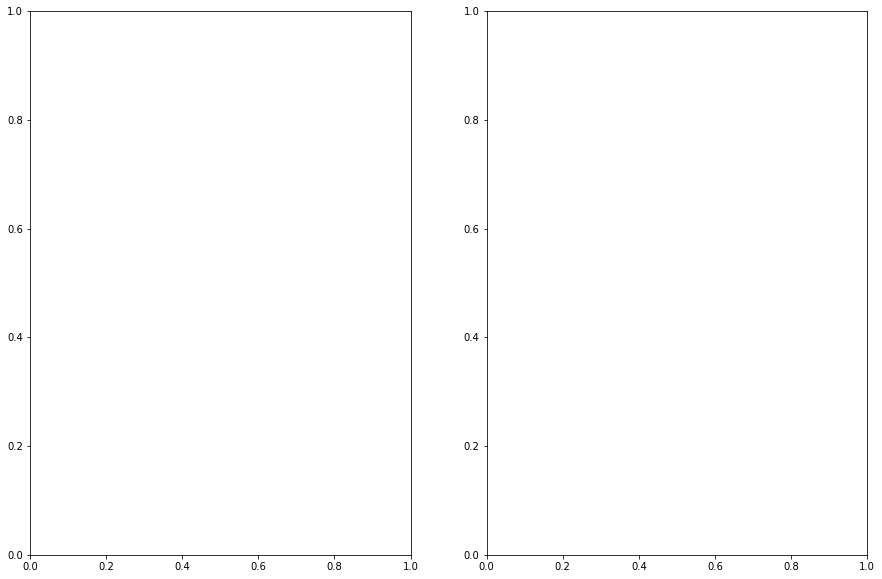

In [82]:
# Plot casualties per year: we expect a decrease
accidents_per_year = accidents.groupby([accidents.Date.dt.year, accidents.Urban_or_Rural_Area])\
    .count()['Longitude']
casualties_per_year = accidents.groupby([accidents.Date.dt.year, accidents.Urban_or_Rural_Area])\
    .agg({'Casualties': 'sum'})
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 10))
ax1.plot(years, accidents_per_year.groupby('Date').sum().values)
ax1.set_title("Accidents per year")
ax2.plot(years, casualties_per_year.groupby('Date').sum().values)
ax2.set_title("Casualties per year");

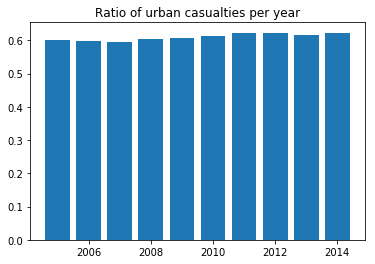

In [16]:
# Plot the ratio of urban casualties
plt.bar(years, [casualties_per_year.loc[y, 1][0] / (casualties_per_year.loc[y, 1][0] + casualties_per_year.loc[y, 2][0]) for y in years])
plt.title("Ratio of urban casualties per year");

In [17]:
accidents.columns

Index(['Longitude', 'Latitude', 'Police_Force', 'Accident_Severity',
       'Number_of_Vehicles', 'Number_of_Casualties', 'Date', 'Day_of_Week',
       'Time', 'Local_Authority_(District)', 'Local_Authority_(Highway)',
       '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit',
       'Junction_Detail', 'Junction_Control', '2nd_Road_Class',
       '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'Casualties'],
      dtype='object')

In [18]:
serie = accidents['Time'].apply(lambda s: str(s)[:2])

In [19]:
accidents['Number_of_Casualties'].describe()

count    1.640486e+06
mean     1.351169e+00
std      8.261026e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      9.300000e+01
Name: Number_of_Casualties, dtype: float64

In [ ]:
print(np.corrcoef(accidents['Number_of_Casualties'], accidents['Urban_or_Rural_Area'])[0][1])
print(np.corrcoef(accidents['Number_of_Casualties'], accidents['Day_of_Week'])[0][1])
print(np.corrcoef(accidents['Casualties'], accidents['Weather_Conditions'])[0][1])
print(np.corrcoef(accidents['Casualties'], accidents['Light_Conditions'])[0][1])


0.11539055994249683
-0.0012050840144811402
-0.004710912712380215
0.11539055994249683

Longitude  Latitude  Police_Force  \
Date Urban_or_Rural_Area                                      
2005 1                       126378    126378        126378   
     2                        72267     72267         72267   
     3                           21        21            90   
2006 1                       119841    119841        119841   
     2                        69293     69293         69293   
     3                           10        10            27   
2007 1                       114542    114542        114542   
     2                        67554     67554         67558   
     3                            4         4            15   
2008 1                       108589    108589        108589   
     2                        61991     61991         61991   
     3                            1         1            11   
2009 1                       104538    104538        104538   
     2                        59016     59016         59016   
2010 1                        99488     99488         99488   
     2                        54926     54926         54926   
2011 1                        99324     99324         99324   
     2                        52150     52150         52150   
2012 1                        95354     95354         95354   
     2                        50217     50217         50217   
2013 1                        90000     90000         90000   
     2                        48660     48660         48660   
2014 1                        96287     96287         96287   
     2                        50035     50035         50035   

                          Accident_Severity  Number_of_Vehicles  \
Date Urban_or_Rural_Area                                          
2005 1                               126378              126378   
     2                                72267               72267   
     3                                   90                  90   
2006 1                               119841              119841   
     2                                69293               69293   
     3                                   27                  27   
2007 1                               114542              114542   
     2                                67558               67558   
     3                                   15                  15   
2008 1                               108589              108589   
     2                                61991               61991   
     3                                   11                  11   
2009 1                               104538              104538   
     2                                59016               59016   
2010 1                                99488               99488   
     2                                54926               54926   
2011 1                                99324               99324   
     2                                52150               52150   
2012 1                                95354               95354   
     2                                50217               50217   
2013 1                                90000               90000   
     2                                48660               48660   
2014 1                                96287               96287   
     2                                50035               50035   

                          Number_of_Casualties    Date  Day_of_Week    Time  \
Date Urban_or_Rural_Area                                                      
2005 1                                  126378  126378       126378  126360   
     2                                   72267   72267        72267   72256   
     3                                      90      90           90      90   
2006 1                                  119841  119841       119841  119832   
     2                                   69293   69293        69293   69284   
     3                                      27      27           27      27   
2007 1      